# DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 1

## Set Environment

In [7]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

[2020-07-08 12:12:34,127] Making new env: CartPole-v0
/Users/angga.muhammad/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(4,)
Action space Discrete(2)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa

## Set Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object.""" 
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define [DQN](https://arxiv.org/pdf/1312.5602.pdf) Agent

In [11]:
class DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps: 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_target, Q_expected)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 100.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 20.19
Episode: 200, Average Score: 71.58
Episode: 215, Average Score: 100.42
Environment solved in 115 episodes! Average Score: 100.42
Episode: 216, Average Score: 100.29
Environment solved in 116 episodes! Average Score: 100.29
Episode: 217, Average Score: 101.79
Environment solved in 117 episodes! Average Score: 101.79
Episode: 218, Average Score: 102.48
Environment solved in 118 episodes! Average Score: 102.48
Episode: 219, Average Score: 102.90
Environment solved in 119 episodes! Average Score: 102.90
Episode: 220, Average Score: 104.34
Environment solved in 120 episodes! Average Score: 104.34
Episode: 221, Average Score: 105.17
Environment solved in 121 episodes! Average Score: 105.17
Episode: 222, Average Score: 107.33
Environment solved in 122 episodes! Average Score: 107.33
Episode: 223, Average Score: 109.33
Environment solved in 123 episodes! Average Score: 109.33
Episode: 224, Average Score: 111.69
Environment solved in 124 episodes! Average Scor

Episode: 302, Average Score: 171.48
Environment solved in 202 episodes! Average Score: 171.48
Episode: 303, Average Score: 169.92
Environment solved in 203 episodes! Average Score: 169.92
Episode: 304, Average Score: 169.29
Environment solved in 204 episodes! Average Score: 169.29
Episode: 305, Average Score: 168.75
Environment solved in 205 episodes! Average Score: 168.75
Episode: 306, Average Score: 168.37
Environment solved in 206 episodes! Average Score: 168.37
Episode: 307, Average Score: 167.29
Environment solved in 207 episodes! Average Score: 167.29
Episode: 308, Average Score: 165.59
Environment solved in 208 episodes! Average Score: 165.59
Episode: 309, Average Score: 165.47
Environment solved in 209 episodes! Average Score: 165.47
Episode: 310, Average Score: 166.83
Environment solved in 210 episodes! Average Score: 166.83
Episode: 311, Average Score: 166.33
Environment solved in 211 episodes! Average Score: 166.33
Episode: 312, Average Score: 164.70
Environment solved in 21

Episode: 390, Average Score: 143.96
Environment solved in 290 episodes! Average Score: 143.96
Episode: 391, Average Score: 142.65
Environment solved in 291 episodes! Average Score: 142.65
Episode: 392, Average Score: 139.80
Environment solved in 292 episodes! Average Score: 139.80
Episode: 393, Average Score: 139.09
Environment solved in 293 episodes! Average Score: 139.09
Episode: 394, Average Score: 137.81
Environment solved in 294 episodes! Average Score: 137.81
Episode: 395, Average Score: 135.93
Environment solved in 295 episodes! Average Score: 135.93
Episode: 396, Average Score: 136.26
Environment solved in 296 episodes! Average Score: 136.26
Episode: 397, Average Score: 135.13
Environment solved in 297 episodes! Average Score: 135.13
Episode: 398, Average Score: 136.03
Environment solved in 298 episodes! Average Score: 136.03
Episode: 399, Average Score: 133.64
Environment solved in 299 episodes! Average Score: 133.64
Episode: 400, Average Score: 133.29

Environment solved in 3

Episode: 478, Average Score: 113.60
Environment solved in 378 episodes! Average Score: 113.60
Episode: 479, Average Score: 112.84
Environment solved in 379 episodes! Average Score: 112.84
Episode: 480, Average Score: 112.79
Environment solved in 380 episodes! Average Score: 112.79
Episode: 481, Average Score: 113.89
Environment solved in 381 episodes! Average Score: 113.89
Episode: 482, Average Score: 113.82
Environment solved in 382 episodes! Average Score: 113.82
Episode: 483, Average Score: 114.02
Environment solved in 383 episodes! Average Score: 114.02
Episode: 484, Average Score: 114.08
Environment solved in 384 episodes! Average Score: 114.08
Episode: 485, Average Score: 114.15
Environment solved in 385 episodes! Average Score: 114.15
Episode: 486, Average Score: 114.79
Environment solved in 386 episodes! Average Score: 114.79
Episode: 487, Average Score: 114.65
Environment solved in 387 episodes! Average Score: 114.65
Episode: 488, Average Score: 114.83
Environment solved in 38

Episode: 566, Average Score: 117.64
Environment solved in 466 episodes! Average Score: 117.64
Episode: 567, Average Score: 117.87
Environment solved in 467 episodes! Average Score: 117.87
Episode: 568, Average Score: 117.76
Environment solved in 468 episodes! Average Score: 117.76
Episode: 569, Average Score: 118.00
Environment solved in 469 episodes! Average Score: 118.00
Episode: 570, Average Score: 118.23
Environment solved in 470 episodes! Average Score: 118.23
Episode: 571, Average Score: 118.39
Environment solved in 471 episodes! Average Score: 118.39
Episode: 572, Average Score: 118.51
Environment solved in 472 episodes! Average Score: 118.51
Episode: 573, Average Score: 118.40
Environment solved in 473 episodes! Average Score: 118.40
Episode: 574, Average Score: 118.70
Environment solved in 474 episodes! Average Score: 118.70
Episode: 575, Average Score: 118.93
Environment solved in 475 episodes! Average Score: 118.93
Episode: 576, Average Score: 119.09
Environment solved in 47

Episode: 654, Average Score: 135.38
Environment solved in 554 episodes! Average Score: 135.38
Episode: 655, Average Score: 135.65
Environment solved in 555 episodes! Average Score: 135.65
Episode: 656, Average Score: 135.72
Environment solved in 556 episodes! Average Score: 135.72
Episode: 657, Average Score: 136.11
Environment solved in 557 episodes! Average Score: 136.11
Episode: 658, Average Score: 136.41
Environment solved in 558 episodes! Average Score: 136.41
Episode: 659, Average Score: 136.58
Environment solved in 559 episodes! Average Score: 136.58
Episode: 660, Average Score: 136.82
Environment solved in 560 episodes! Average Score: 136.82
Episode: 661, Average Score: 137.11
Environment solved in 561 episodes! Average Score: 137.11
Episode: 662, Average Score: 137.15
Environment solved in 562 episodes! Average Score: 137.15
Episode: 663, Average Score: 138.33
Environment solved in 563 episodes! Average Score: 138.33
Episode: 664, Average Score: 138.59
Environment solved in 56

Episode: 742, Average Score: 178.12
Environment solved in 642 episodes! Average Score: 178.12
Episode: 743, Average Score: 179.81
Environment solved in 643 episodes! Average Score: 179.81
Episode: 744, Average Score: 181.06
Environment solved in 644 episodes! Average Score: 181.06
Episode: 745, Average Score: 180.54
Environment solved in 645 episodes! Average Score: 180.54
Episode: 746, Average Score: 180.60
Environment solved in 646 episodes! Average Score: 180.60
Episode: 747, Average Score: 182.35
Environment solved in 647 episodes! Average Score: 182.35
Episode: 748, Average Score: 182.84
Environment solved in 648 episodes! Average Score: 182.84
Episode: 749, Average Score: 182.67
Environment solved in 649 episodes! Average Score: 182.67
Episode: 750, Average Score: 183.02
Environment solved in 650 episodes! Average Score: 183.02
Episode: 751, Average Score: 183.20
Environment solved in 651 episodes! Average Score: 183.20
Episode: 752, Average Score: 184.90
Environment solved in 65

Episode: 830, Average Score: 429.04
Environment solved in 730 episodes! Average Score: 429.04
Episode: 831, Average Score: 436.93
Environment solved in 731 episodes! Average Score: 436.93
Episode: 832, Average Score: 444.91
Environment solved in 732 episodes! Average Score: 444.91
Episode: 833, Average Score: 454.63
Environment solved in 733 episodes! Average Score: 454.63
Episode: 834, Average Score: 462.73
Environment solved in 734 episodes! Average Score: 462.73
Episode: 835, Average Score: 470.84
Environment solved in 735 episodes! Average Score: 470.84
Episode: 836, Average Score: 478.46
Environment solved in 736 episodes! Average Score: 478.46
Episode: 837, Average Score: 486.40
Environment solved in 737 episodes! Average Score: 486.40
Episode: 838, Average Score: 493.32
Environment solved in 738 episodes! Average Score: 493.32
Episode: 839, Average Score: 501.15
Environment solved in 739 episodes! Average Score: 501.15
Episode: 840, Average Score: 509.46
Environment solved in 74

Episode: 918, Average Score: 945.08
Environment solved in 818 episodes! Average Score: 945.08
Episode: 919, Average Score: 945.08
Environment solved in 819 episodes! Average Score: 945.08
Episode: 920, Average Score: 942.46
Environment solved in 820 episodes! Average Score: 942.46
Episode: 921, Average Score: 942.46
Environment solved in 821 episodes! Average Score: 942.46
Episode: 922, Average Score: 937.28
Environment solved in 822 episodes! Average Score: 937.28
Episode: 923, Average Score: 937.28
Environment solved in 823 episodes! Average Score: 937.28
Episode: 924, Average Score: 937.28
Environment solved in 824 episodes! Average Score: 937.28
Episode: 925, Average Score: 937.28
Environment solved in 825 episodes! Average Score: 937.28
Episode: 926, Average Score: 937.28
Environment solved in 826 episodes! Average Score: 937.28
Episode: 927, Average Score: 937.28
Environment solved in 827 episodes! Average Score: 937.28
Episode: 928, Average Score: 937.28
Environment solved in 82

## Evaluate The Agent

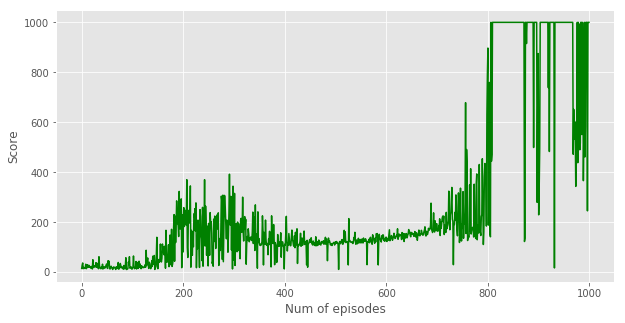

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/DQN_{ENV_NAME}.pth'));

In [18]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(200):
        
        env.render() # render the screen
        action = agent.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

Episode: 1, Average Score: 200.00
Episode: 2, Average Score: 200.00
Episode: 3, Average Score: 200.00
Episode: 4, Average Score: 200.00
Episode: 5, Average Score: 200.00


---